
--- SUPERDENSE CODING en PYQUIL ---
DECLARE ro BIT[2]
H 0
CNOT 0 1
Z 0
X 0
CNOT 0 1
H 0
MEASURE 0 ro[0]
MEASURE 1 ro[1]

Bob's result: Counter({'11': 100})


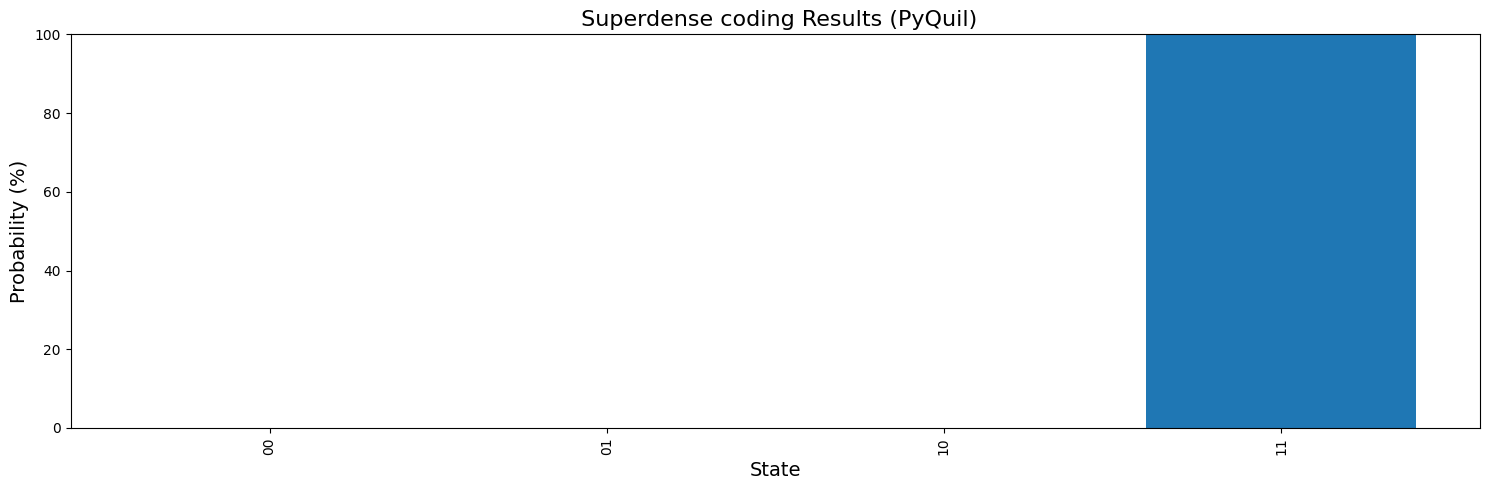

In [2]:
# Superdense coding example using the framework-agnostic 'quantumgateway' primitives.
# The circuit can be translated and simulated on multiple backends (Braket, Qiskit, Cirq, PennyLane, PyQuil).
# - QuantumCircuit: allows us to create a quantum circuit with qubits and classical bits.
from quantumgateway.quantum_circuit import QuantumCircuit, QuantumGate

# Import the core tools from quantumgateway:
# - QuantumGate: represents operations (gates) applied to qubits.
# Translators allow us to "speak the language" of different quantum platforms.
from quantumgateway.quantum_translator.braket_translator import BraketTranslator
from quantumgateway.quantum_translator.cirq_translator import CirqTranslator
from quantumgateway.quantum_translator.qiskit_translator import QiskitTranslator
from quantumgateway.quantum_translator.pennylane_translator import PennyLaneTranslator
from quantumgateway.quantum_translator.pyquil_translator import PyQuilTranslator

# Translators are imported so translate_to_framework can render the circuit for each backend.
from quantumgateway.main import translate_to_framework, simulate_circuit

import matplotlib.pyplot as plt

# -------------------------
# Superdense protocol
# Preparation
# 
# ------------------------------------------------------
# Step 1: Alice and Bob create a shared entangled pair.
# ------------------------------------------------------
# Story: Before communication, Alice and Bob meet and create an entangled state.
# Alice keeps qubit 0, Bob keeps qubit 1. This is their shared "quantum resource".

# Create a circuit with 2 qubits and 2 classical bits.
qc = QuantumCircuit(2, 2)
# Put Alice's qubit (0) into superposition with a Hadamard gate.
qc.add_gate(QuantumGate("h", [0]))
# Entangle Alice's and Bob's qubits using CNOT (control=0, target=1).
qc.add_gate(QuantumGate("cnot", [0, 1]))
# Now Alice and Bob share the Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2.

# ------------------------------------------------------
# Step 2: Alice encodes her 2 classical bits.
# ------------------------------------------------------
# Story: Alice wants to send her message. She applies specific gates to her qubit (0):
# - "00": do nothing (I gate)
# - "01": apply X (bit-flip)
# - "10": apply Z (phase-flip)
# - "11": apply Z then X

# Alice chooses the 2-bit message ('00','01','10' or '11') she wants to send to Bob.
bits = "11"  

if bits == "00":
    pass  # No action needed for message "00"
elif bits == "01":
    qc.add_gate(QuantumGate("x", [0]))  # Apply X gate
elif bits == "10":
    qc.add_gate(QuantumGate("z", [0]))  # Apply Z gate
elif bits == "11":
    qc.add_gate(QuantumGate("z", [0]))  # Apply Z then X
    qc.add_gate(QuantumGate("x", [0]))
else:
    raise ValueError("Invalid message. Use '00','01','10','11'.")

# ------------------------------------------------------
# Step 3: Bob decodes the message.
# ------------------------------------------------------
# Story: Alice now sends her qubit physically to Bob. 
# Bob now has both qubits and must decode the message.

# Bob applies a CNOT (control=0, target=1).
qc.add_gate(QuantumGate("cnot", [0, 1]))

# Then Bob applies a Hadamard to qubit 0.
qc.add_gate(QuantumGate("h", [0]))
# After these operations, the 2 qubits are in a state where 
# a simple measurement reveals Alice's original 2-bit message.

# ------------------------------------------------------
# Step 4: Measurement
# ------------------------------------------------------
# Bob measures both qubits to extract the classical bits.
qc.add_gate(QuantumGate("measure", [0, 0]))  # Measure Alice's qubit → classical bit 0
qc.add_gate(QuantumGate("measure", [1, 1]))  # Measure Bob's qubit → classical bit 1

# ------------------------------------------------------
# Step 5: Simulation
# ------------------------------------------------------
# We select which framework to use for simulation (e.g., 'qiskit','cirq','pennylane','pyquil','amazonbraket')
selected_framework = 'pyquil'  
# Translate the circuit from "quantumgateway" to the chosen framework
translated_circuit = translate_to_framework(qc, selected_framework)
print(f"\n--- SUPERDENSE CODING en {selected_framework.upper()} ---")

translated_circuit.print_circuit()
# Run the circuit in the chosen backend and see the results.
counts = simulate_circuit(qc, selected_framework)
# Story: The measurement result corresponds to the 2-bit message Alice sent.
print("Bob's result:", counts) 

# =======================================
# Post-processing and visualization
# =======================================

# Total number of shots
total_shots = sum(counts.values())
# Convert counts into percentages to better visualize probabilities
percentage_counts = {state: count / total_shots * 100 for state, count in counts.items()}

# Define all possible 2-qubit states (00, 01, 01, 11) to show on the histogram
all_states = [format(i, '02b') for i in range(2**2)]

# Mapping for pretty backend names in the plot title
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}
# Create a bar plot showing the probabilities
plt.figure(figsize=(15,5))
plt.bar(all_states, [percentage_counts.get(state, 0) for state in all_states])
plt.xlabel('State', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title(f' Superdense coding Results ({backend_names[selected_framework]})', fontsize=16)
plt.xticks(rotation='vertical')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

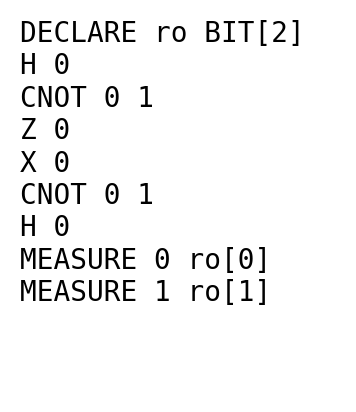

In [12]:
# The following is to save the circuit of each platform in an image
import matplotlib.pyplot as plt
import io
import sys

# Redirect stdout to capture circuit text
stdout = sys.stdout
sys.stdout = io.StringIO()

selected_framework = 'pyquil'  # Change this to the desired framework
translated_circuit = translate_to_framework(qc, selected_framework)
translated_circuit.print_circuit()

printed_circuit = sys.stdout.getvalue()
sys.stdout = stdout

# Split lines to estimate size
lines = printed_circuit.split("\n")
max_line_length = max(len(line) for line in lines)
num_lines = len(lines)

# Auto-adjust figure size based on text
scale = 1.8
fig_width = max_line_length * 0.12
fig_height = num_lines * 0.22

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=200)
ax.text(0, 1, printed_circuit,
        ha='left', va='top',
        family='monospace', fontsize=10,
        transform=ax.transAxes)


ax.axis('off')

# Save the figure with all extra space removed
plt.savefig("Fig10a.eps",
            dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

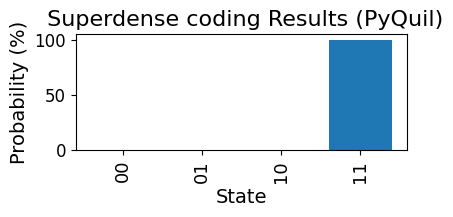

In [13]:
# and the following code is to save the image from the histogram

# Total number of shots
total_shots = sum(counts.values())
# Convert counts into percentages to better visualize probabilities
percentage_counts = {state: count / total_shots * 100 for state, count in counts.items()}

# ----------------------------
# PREPARE DATA FOR PLOTTING
# ----------------------------
# Generate all possible 2-qubit states in binary order: '00', '01', '10', '11'
all_states = [format(i, '02b') for i in range(2**2)]

# Create a narrower and taller figure
plt.figure(figsize=(4, 2))  # width=6, height=4 (adjust if needed)

# Create the bar plot
plt.bar(all_states, [percentage_counts.get(state, 0) for state in all_states])

# Mapping for pretty backend names in the plot title
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# Labels with larger fonts
plt.xlabel('State', fontsize=14)    
plt.ylabel('Probability (%)', fontsize=14)
plt.title(f' Superdense coding Results ({backend_names[selected_framework]})', fontsize=16)

# More readable ticks
plt.xticks(rotation='vertical',fontsize=13)  # Rotate x-axis labels
plt.yticks(fontsize=12)

# Reduce whitespace at the bottom
#plt.subplots_adjust(bottom=0.1)  # ajusta este valor según lo necesario
# Remove extra white space
plt.tight_layout(pad=0.1)

# Save adjusted image
plt.savefig("Fig10b.eps",dpi=300, bbox_inches='tight', pad_inches=0.05)

# Show the histogram
plt.show()